# MNIST. Соревнование Kaggle

Целью данного соревнования является определение рукописных цифр. Данную задачу решим двумя способами: с помощью полносвязной сети и сверточной сети

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Выгрузка и предобработка данных

In [52]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df.shape

(42000, 785)

Проверим пустые значения

In [54]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [6]:
df.isna().sum().sum()

0

Отделим от датасета целевую переменную

In [55]:
y = df['label']

In [56]:
X = df.drop('label', axis='columns')

In [57]:
y.shape, X.shape

((42000,), (42000, 784))

Посмотрим на распределение классов

<AxesSubplot:>

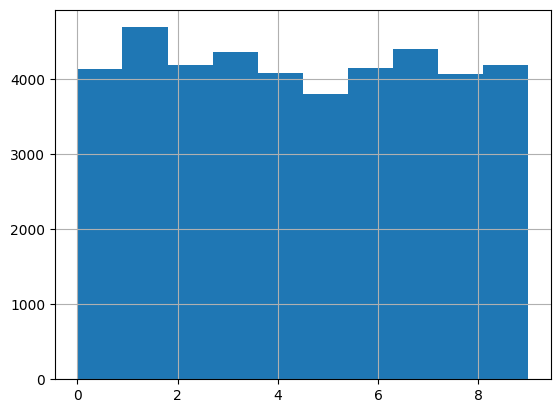

In [58]:
y.hist()

Как видим все классы, почти распределены равномерно

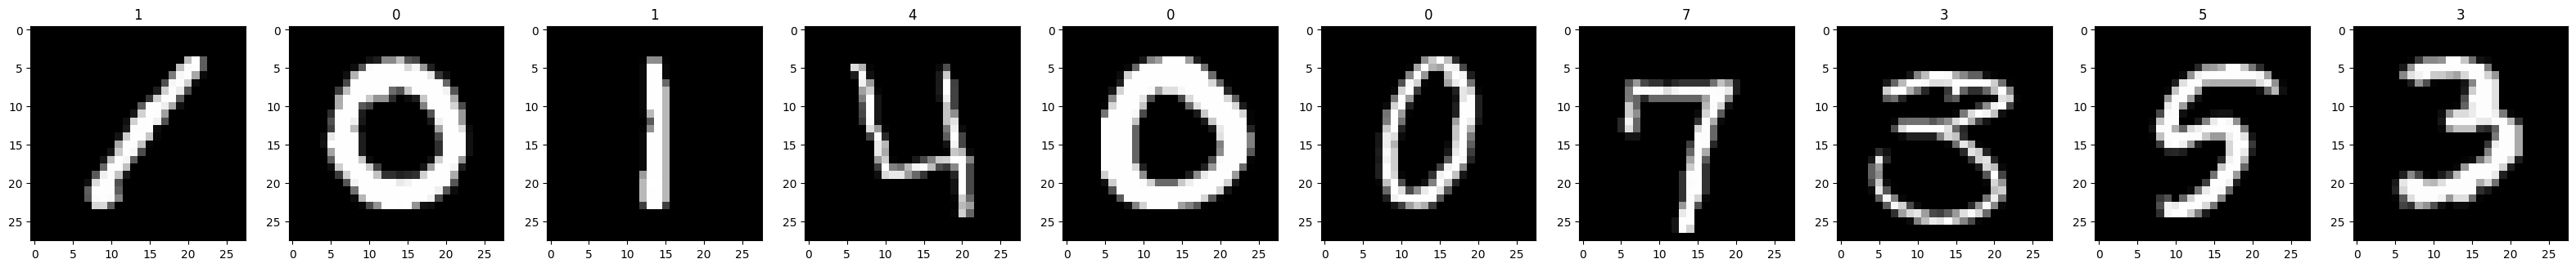

In [59]:
fig, ax = plt.subplots(1, 10, figsize=(40,10))
for i in range(10):
    im = X.iloc[i].to_numpy().reshape(28,28)
    ax[i].imshow(im, cmap='gray')
    ax[i].set_title(str(y[i]))

## Построение моделей

### Разбиение на тренировочную и валидационную выборки

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)
print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)

X_train.shape: (29400, 784)
X_val.shape: (12600, 784)
y_train.shape: (29400,)
y_val.shape: (12600,)


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [62]:
X_train_t = torch.FloatTensor(X_train.to_numpy())
y_train_t = torch.LongTensor(y_train.to_numpy())
X_val_t = torch.FloatTensor(X_val.to_numpy())
y_val_t = torch.LongTensor(y_val.to_numpy())

train_dataloader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=10)
val_dataloader = DataLoader(TensorDataset(X_val_t, y_val_t))

### Функция обучения

In [64]:
from tqdm import tqdm
def train(model, loss_fn, opt, train_loses, dataloader, epoch):
    for _ in tqdm(range(epoch)):
        for i, (X_batch, y_batch) in enumerate((dataloader)):
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            if i % 1000 == 0:
                train_loses.append(loss.item())
    return train_loses

In [65]:
from sklearn.metrics import accuracy_score
def get_metrics(model, X_train_t, y_train_t, X_val_t, y_val_t):
    with torch.no_grad():
        y_train_pred = model(X_train_t)
        pred_train_label = abs(y_train_pred.numpy()).argmax(axis=1)
        a_train_fln = accuracy_score(y_train_t.numpy(), pred_train_label)
        y_val_pred = model(X_val_t)
        pred_val_label = abs(y_val_pred.numpy()).argmax(axis=1)
        a_val_fln = accuracy_score(y_val_t.numpy(), pred_val_label)
    return a_train_fln, a_val_fln

### Полносвязная нейросеть без скрытых слоев

In [66]:
class FullNet(nn.Module):
    def __init__(self, n_input=784, n_output=10):
        super().__init__()
        self.linear = nn.Linear(n_input, n_output)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        return x

In [67]:
lr = 0.1
model_fln = FullNet()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_fln.parameters(), lr=lr)
train_loses_fln = []

In [68]:
train_loses_fln = train(model_fln, loss_fn, opt, train_loses_fln, train_dataloader,100)

  6%|██████▍                                                                                                     | 6/100 [00:11<02:48,  1.79s/it]

<AxesSubplot:>

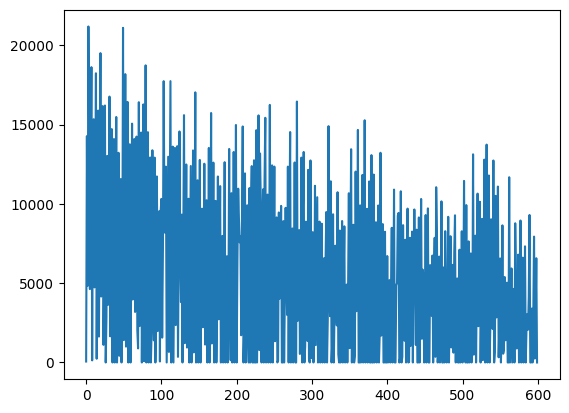

In [31]:
sns.lineplot(train_loses_fln)

In [32]:
a_train_fln, a_val_fln = get_metrics(model_fln, X_train_t, y_train_t, X_val_t, y_val_t)
print("Accuracy train:", a_train_fln)
print("Accuracy val:", a_val_fln)

Accuracy train: 0.3949319727891156
Accuracy val: 0.3900793650793651


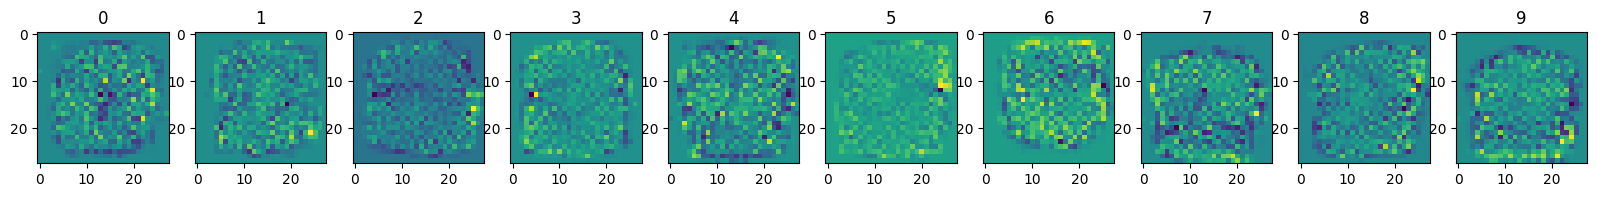

In [28]:
fln_w = model_fln.linear.weight.detach().numpy()
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    im = fln_w[i].reshape(28,28)
    ax[i].imshow(im)
    ax[i].set_title(str(i))

Как мы видим, нейронная сеть без скрытых слоев показывает не очень хорошие результаты

### Полносвязанная нейросеть с 1 скрытым слоем

In [29]:
class FullHideNet(nn.Module):
    def __init__(self, n_input=784, n_hiden_neurons=225, n_output=10):
        super().__init__()
        self.linear_1 = nn.Linear(n_input, n_hiden_neurons)
        self.linear_2 = nn.Linear(n_hiden_neurons, n_output)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [33]:
lr = 1e-3
model_fhn = FullHideNet()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_fhn.parameters(), lr=lr)
train_loses_fhn = []

In [34]:
train_loses_fhn = train(model_fhn, loss_fn, opt, train_loses_fhn, train_dataloader, 200)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [09:49<00:00,  2.95s/it]


<AxesSubplot:>

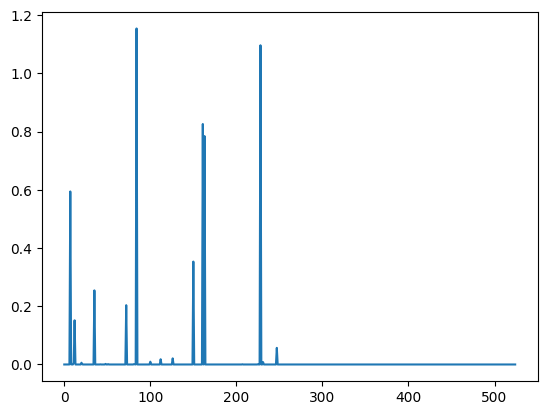

In [35]:
sns.lineplot(train_loses_fhn[75:])

In [36]:
a_train_fhn, a_val_fhn = get_metrics(model_fhn, X_train_t, y_train_t, X_val_t, y_val_t)
print("Accuracy train:", a_train_fhn)
print("Accuracy val:", a_val_fhn)

Accuracy train: 0.9927891156462585
Accuracy val: 0.9614285714285714


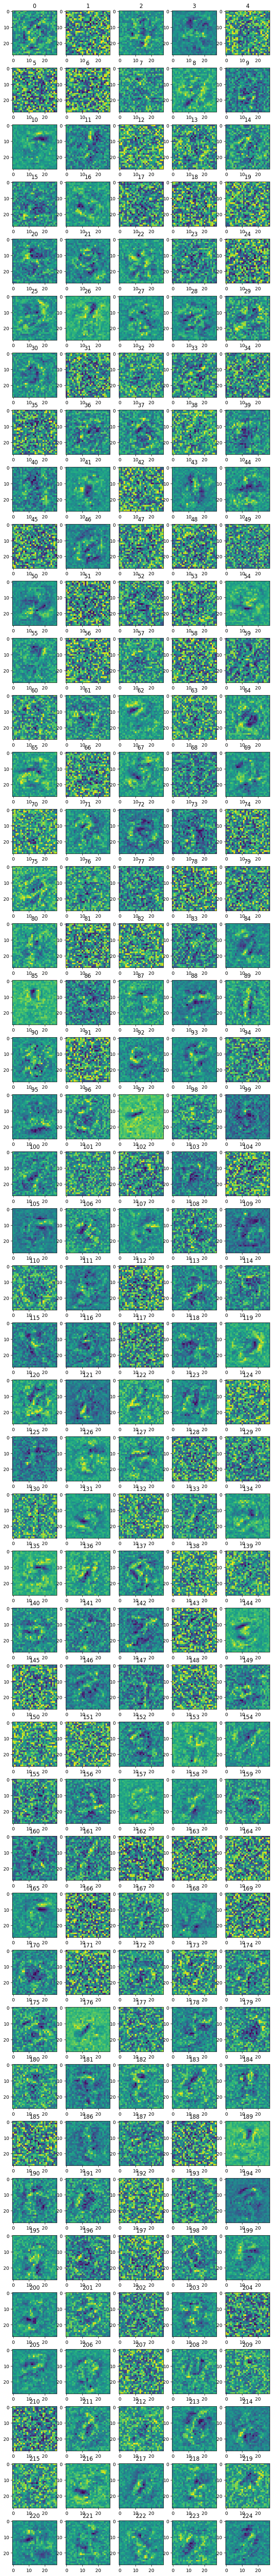

In [37]:
layer_1_w = model_fhn.linear_1.weight.detach().numpy()
fig, ax = plt.subplots(int(layer_1_w.shape[0] / 5), 5, figsize=(10,100))
for i, w in enumerate(layer_1_w):
    im = layer_1_w[i].reshape(28,28)
    ax[i//5][i%5].imshow(im)
    ax[i//5][i%5].set_title(str(i))

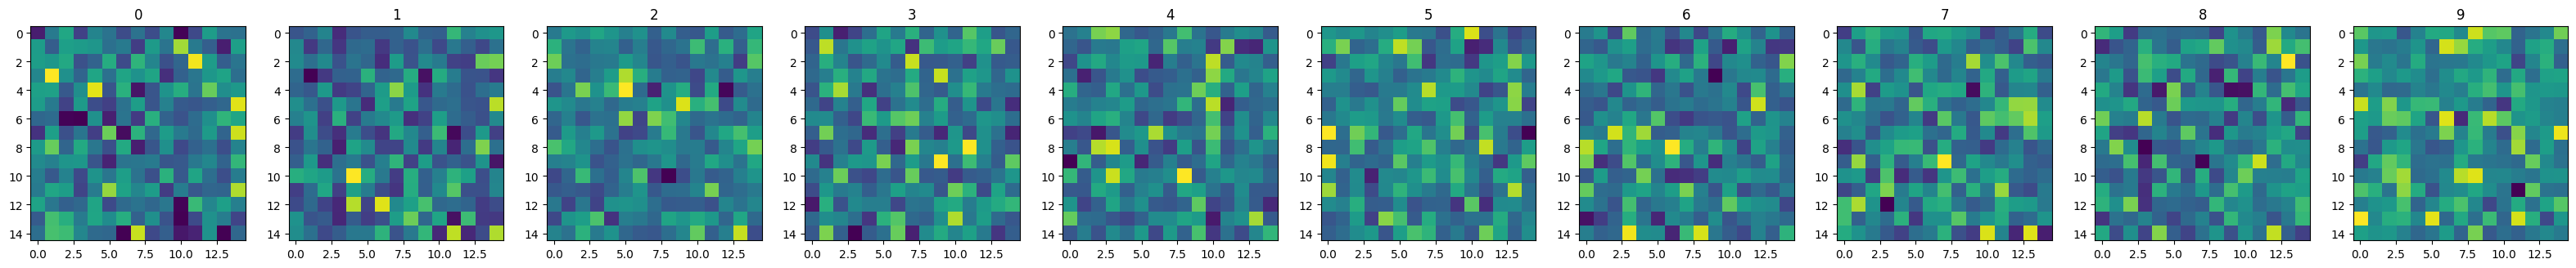

In [38]:
layer_2_w = model_fhn.linear_2.weight.detach().numpy()
fig, ax = plt.subplots(1, 10, figsize=(40, 10))
for i, w in enumerate(layer_2_w):
    im = layer_2_w[i].reshape(15,15)
    ax[i].imshow(im)
    ax[i].set_title(str(i))

### Сравнение метрик полносвязанных сетей

В качестве метрики мы считали accuracy

In [39]:
df_metrics = pd.DataFrame({
    'net_name':[
        'Полносвязанная без скрытых слоев',
        'Полносвязанная без скрытых слоев',
        'Полносвязанная c 1 скрытым слоем',
        'Полносвязанная c 1 скрытым слоем'
    ],
    'name':[
        'train',
        'val',
        'train',
        'val',
    ],
    'value':[
        a_train_fln,
        a_val_fln,
        a_train_fhn,
        a_val_fhn,
    ]
})
df_metrics

,net_name,name,value
0,Полносвязанная без скрытых слоев,train,0.394932
1,Полносвязанная без скрытых слоев,val,0.390079
2,Полносвязанная c 1 скрытым слоем,train,0.992789
3,Полносвязанная c 1 скрытым слоем,val,0.961429


<AxesSubplot:xlabel='net_name', ylabel='value'>

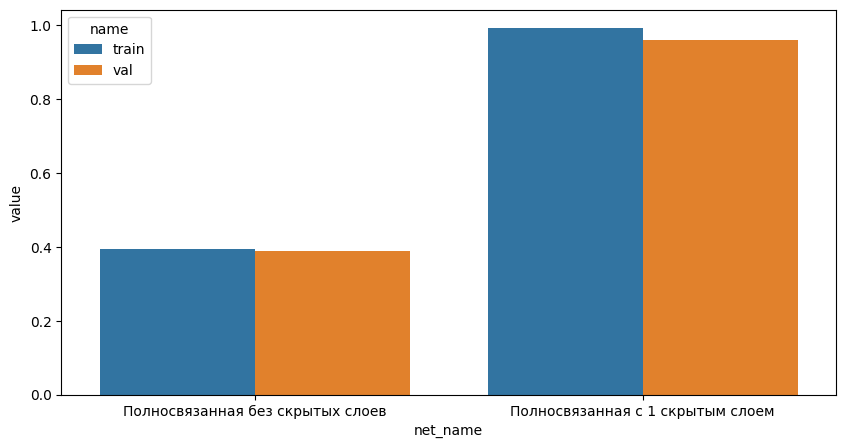

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df_metrics, x='net_name', y='value', hue='name', ax=ax)

Из графика мы видим, полносвязанная сеть с одним 1 скрытым слотом работает намного лучше, чем нейронная сеть без скрытых слоев. Попробуем еще добавить скрытых слоев

### Полносвязанная нейронная сеть с 2 скрытыми слоями и слоем dropout

In [41]:
class FullHideSecondNet(nn.Module):
    def __init__(self, n_input=784, n_hiden_neurons=(225, 128), n_output=10):
        super().__init__()
        self.linear_1 = nn.Linear(n_input, n_hiden_neurons[0])
        self.linear_2 = nn.Linear(n_hiden_neurons[0], n_hiden_neurons[1])
        self.linear_3 = nn.Linear(n_hiden_neurons[1], n_output)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.25)
    def forward(self, x):
        x = self.relu(self.linear_1(x))
        x = self.drop(x)
        x = self.relu(self.linear_2(x))
        x = self.linear_3(x)
        return x

In [42]:
lr = 1e-3
model_fhsn = FullHideSecondNet()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_fhsn.parameters(), lr=lr)
train_loses_fhsn = []

In [50]:
train_loses_fhsn = train(model_fhsn, loss_fn, opt, train_loses_fhsn, train_dataloader, 100)

 16%|█████████████████                                                                                          | 16/100 [00:59<05:27,  3.90s/it]

<AxesSubplot:>

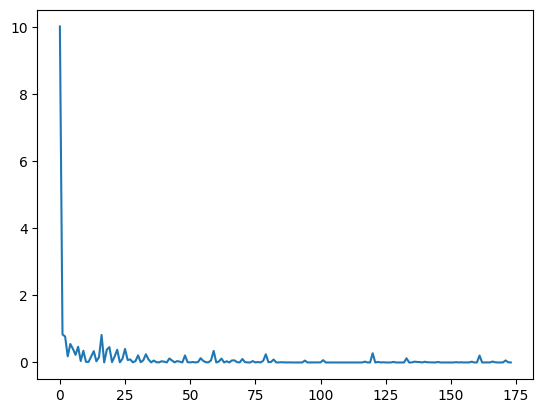

In [45]:
sns.lineplot(train_loses_fhsn)

In [ ]:
a_train_fhsn, a_val_fhsn = get_metrics(model_fhsn, X_train_t, y_train_t, X_val_t, y_val_t)
print("Accuracy train:", a_train_fhsn)
print("Accuracy val:", a_val_fhsn)

Accuracy train: 0.9957482993197279
Accuracy val: 0.9668253968253968


### Сравнение метрик

In [ ]:
df_metrics_sec = pd.DataFrame({
    'net_name':[
        'Полносвязанная c 2 скрытыми слоями',
        'Полносвязанная c 2 скрытыми слоями'
    ],
    'name':[
        'train',
        'val',
    ],
    'value':[
        a_train_fhsn,
        a_val_fhsn,
    ]
})
df_metrics_sec

,net_name,name,value
0,Полносвязанная c 2 скрытыми слоями,train,0.985102
1,Полносвязанная c 2 скрытыми слоями,val,0.954921


In [ ]:
df_metrics = pd.concat([df_metrics, df_metrics_sec], axis=0).reset_index(drop=True)
df_metrics.sort_values(by='value', ascending=False)[df_metrics['name'] == 'val']

/var/folders/zz/zyxvpxvq6csfxvn_n0002g9m000ltd/T/ipykernel_99215/2476537444.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_metrics.sort_values(by='value', ascending=False)[df_metrics['name'] == 'val']


,net_name,name,value
5,Полносвязанная c 2 скрытыми слоями,val,0.954921
7,Полносвязанная c 2 скрытыми слоями,val,0.954921
3,Полносвязанная c 1 скрытым слоем,val,0.933968
1,Полносвязанная без скрытых слоев,val,0.220476


<Axes: xlabel='net_name', ylabel='value'>

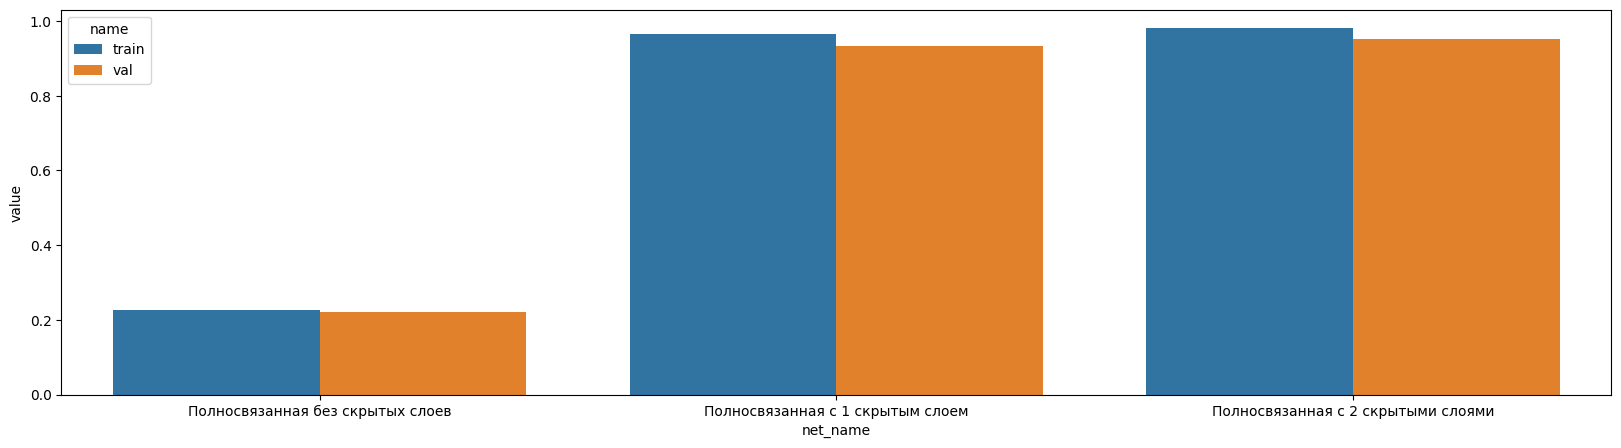

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_metrics, x='net_name', y='value', hue='name', ax=ax)

### Сверточная сеть

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1)    #28x28
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))                                             #14x14
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))               #12x12
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))                                             #6x6
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3))               #4x4
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))                                             #2x2
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=256, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
class MyCNNPaint(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), padding=1)
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=1) #28x28
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))                                         #14x14
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=8, kernel_size=(3,3))            #12x12
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))                                         #6x6
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=5, kernel_size=(3,3), padding=1)  #6x6
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=180, out_features=100)
        self.linear2 = nn.Linear(in_features=100, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv0(x))
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
lr = 1e-3
model_cnn = MyCNN()
# model_cnn = MyCNNPaint()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_cnn.parameters(), lr=lr)
train_loses_cnn = []

In [ ]:
X_train_t_cnn = X_train_t.reshape([X_train_t.shape[0], 28,28])
X_train_t_cnn = X_train_t_cnn[:,None,:,:]
train_dataloader_cnn = DataLoader(TensorDataset(X_train_t_cnn, y_train_t), batch_size=1)

In [ ]:
train_loses_cnn = train(model_cnn, loss_fn, opt, train_loses_cnn, train_dataloader_cnn, 50)

100%|██████████| 50/50 [48:41<00:00, 58.43s/it]


<Axes: >

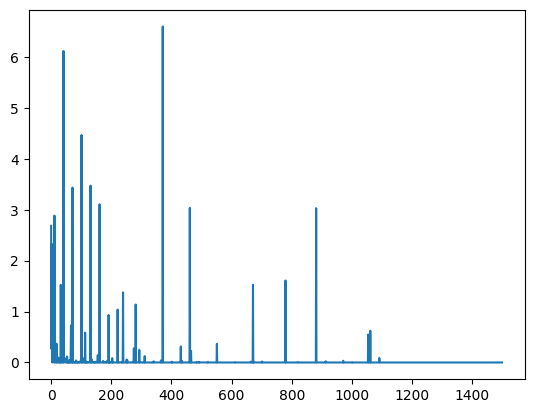

In [ ]:
sns.lineplot(train_loses_cnn)

In [ ]:
X_train_t_cnn = X_train_t.reshape([X_train_t.shape[0], 28,28])
X_train_t_cnn = X_train_t_cnn[:,None,:,:]
X_val_t_cnn = X_val_t.reshape([X_val_t.shape[0], 28,28])
X_val_t_cnn = X_val_t_cnn[:,None,:,:]
a_train_cnn, a_val_cnn = get_metrics(model_cnn, X_train_t_cnn, y_train_t, X_val_t_cnn, y_val_t)
print("Accuracy train:", a_train_cnn)
print("Accuracy val:", a_val_cnn)

In [ ]:
torch.save(model_cnn, 'model_cnn.pt')

## Предсказания на тестовых данных

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test_t = torch.FloatTensor(df_test.to_numpy())
X_test_t

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
def test_write_pred(model, name):
    with torch.no_grad():
        pred = model(X_test_t)
        pred = pred.detach().numpy().argmax(axis=1)
    df_pred = pd.DataFrame(pred, columns=['Label'])
    df_pred.index += 1
    df_pred.index.name = 'ImageId'
    df_pred.to_csv(name)

In [ ]:
test_write_pred(model_fhn, 'pred_fhn.csv')

In [ ]:
test_write_pred(model_fhsn, 'pred_fhsn.csv')

In [ ]:
X_test_t = X_test_t.reshape([X_test_t.shape[0], 28,28])
X_test_t = X_test_t[:,None,:,:]
test_write_pred(model_cnn, 'pred_cnn.csv')